# Introduction


This notebook aims for providing an experiment of traditional pair trading with parameter autotuning grid search.

This experiment is based on [backtrader](https://www.backtrader.com/) which has an agnosticism philosophy that the data come in as a per-sample basis. Indicators are recalculate when new data come in.

And [Quantstat](https://github.com/ranaroussi/quantstats) for metrics and graphical analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, json, pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
import backtrader as bt
import quantstats as qs

from tqdm import tqdm
from itertools import combinations
# Find parameters in `params.py`
from params import *
from utils.deletion import clear_previous_res
from utils.gridsearch import gridsearch
from utils.read2df import read2df
from utils.cointncorr import CointnCorr
from utils.resanalyse import res_analyse
from utils.pyfolioprocess import pyfolio_process
from utils.rlmetrics import get_return, get_metrics
from envs.env_gridsearch import KellyCriterionIndicator, PairTrading

folder_path = "result/gridsearch"
os.makedirs(folder_path, exist_ok=True)

# Data Preparation

Load proper `symbols` and `freqs` from the analysis of `trade_preliminaries.ipynb`

Then is split for train data and test data from `start_date` until `trade_date`, and start trade after `trade_date`.

In [2]:
# Load from cointncorr pickle file
with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

# dfs = read2df(symbols, freqs)
dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

freq_position = list(freqs.keys()).index(data[1])

df0 = dfs[freq_position][dfs[freq_position]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[freq_position][dfs[freq_position]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

pair, best_freq = data 
best_pair = f"{pair[0]}_{pair[1]}"

print("===========================================")
print(f"Data loaded as: {best_pair} under {best_freq} interval")
print("===========================================")

# have a preview
dfs[0].head(20)

Data loaded as: ETHEUR_ETHGBP under 1m interval


,time,open,high,low,close,volume,tic,itvl,datetime
0,1592560859999,207.15,207.15,207.15,207.15,0.00000,ETHEUR,1m,2020-06-19 10:00:59.999
1,1592560859999,184.44,184.44,184.44,184.44,0.05500,ETHGBP,1m,2020-06-19 10:00:59.999
2,1592560919999,207.15,207.15,207.15,207.15,0.00000,ETHEUR,1m,2020-06-19 10:01:59.999
3,1592560919999,184.78,184.78,184.78,184.78,0.68455,ETHGBP,1m,2020-06-19 10:01:59.999
4,1592560979999,207.15,207.15,207.15,207.15,0.00000,ETHEUR,1m,2020-06-19 10:02:59.999
5,1592560979999,184.78,184.78,184.78,184.78,0.00000,ETHGBP,1m,2020-06-19 10:02:59.999
6,1592561039999,206.00,206.00,206.00,206.00,0.18051,ETHEUR,1m,2020-06-19 10:03:59.999
7,1592561039999,184.78,184.78,184.78,184.78,0.00000,ETHGBP,1m,2020-06-19 10:03:59.999
8,1592561099999,206.00,206.00,206.00,206.00,0.00000,ETHEUR,1m,2020-06-19 10:04:59.999
9,1592561099999,184.78,184.78,184.78,184.78,0.00000,ETHGBP,1m,2020-06-19 10:04:59.999


In [3]:
'''
Set data before `trade_data` as training data, after `trade_data` is trade_data
'''

trains, tests = [], []
for i in range(len(dfs)):
    trains.append(dfs[i][(dfs[i]['datetime'] > start_date) & (dfs[i]['datetime'] < trade_date)].reset_index(drop=True))
    tests.append(dfs[i][dfs[i]['datetime'] >= trade_date].reset_index(drop=True))

# Cointegration and Correlation

We need to make sure that our data is capable for pair trading. 
At least it should have the tendency to merge together therefore we test the coint and corr between every possible two pairs 

Calculate daily coint and corr for all the pairs
Consider 1 day with 1440 minutes.

Delete the pickle file in the `\result` if want to recalculate

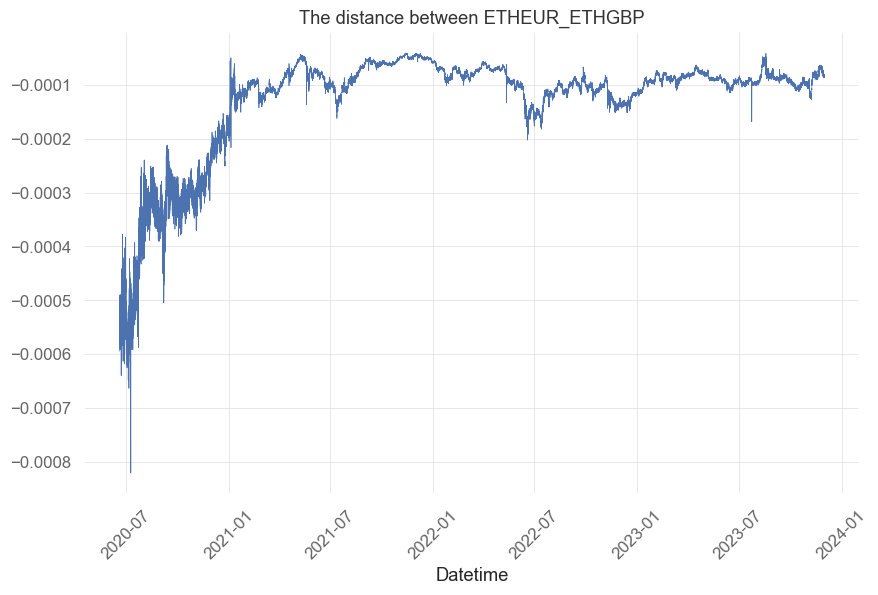

In [4]:
import matplotlib.pyplot as plt

distance = df0['close']-df1['close']
stddev = np.std(distance)

plt.plot(df0['datetime'], distance, linewidth=0.5)

# Set labels and title
plt.xlabel('Datetime')
plt.xticks(rotation=45) 

plt.title(f"The distance between {best_pair}")

# Display the plot
plt.show()

In [5]:
freq_pos = list(freqs.keys()).index(best_freq)

traindata0 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
traindata1 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

# How come a datetime of 2022(ish) is converted to 738786.635416655???
datafeed0 = bt.feeds.PandasData(
        dataname=traindata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeed1 = bt.feeds.PandasData(
        dataname=traindata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeeds = [datafeed0, datafeed1]
print(f"length of train set is {len(traindata0)}")

length of train set is 1591841


# Execute the Strategy

We should firstly have a test run on the strategy to make sure it works.

Submitted a PR for Backtrader-OLS results

> https://github.com/mementum/backtrader/pull/487

In [6]:
def cerebro_run(datafeeds, param):

    cerebro = bt.Cerebro()

    cerebro.adddata(datafeeds[0], name=best_pair.split('_')[0])
    cerebro.adddata(datafeeds[1], name=best_pair.split('_')[1])

    cerebro.broker.set_cash(1)  # Set initial capital

    # Binance fee structure
    # https://www.binance.com/en-BH/support/faq/binance-futures-fee-structure-fee-calculations-360033544231
    cerebro.broker.setcommission(commission=0.0002)

    # comminfo = PairTradingCommInfo(commission=0.002, margin=1000, mult=10)
    # cerebro.broker.addcommissioninfo(comminfo)

    cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
    # cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturns', compression=60)
    # cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
    # cerebro.addsizer(KellyCriterionSizer)

    cerebro.addstrategy(PairTrading, **param)
    strats = cerebro.run()
    return strats

An Experimental Run

In [7]:
# prefix = "Experiment"
# clear_previous_res(prefix)

# # A test run
# # https://github.com/mementum/backtrader/blob/master/backtrader/indicators/ols.py
# # It always returns weird error like the number of params
# a
# # 1. The default OLS indicator is precarious, always weird errors like num of params, or sometimes index error
# # 2. The custom indicator is precious as well. not trustworthy

# param = {'kellycriterion': False, 'OPEN_THRE':1.7, 'CLOS_THRE':0.3, 'period': 1300, 'verbose':1, 'prefix':prefix, 'fixed_amount':0.1}
# experiment = cerebro_run(datafeeds, param)

# Grid Search the Strategy

The grid search on all the possible results for an optimal outcome

Define `scoring` function and `param_grid` for grid search

then `gridsearch` from `utils.gridsearch`

In [8]:
prefix = "Gridsearch"
clear_previous_res(prefix)

datafeeds = [datafeed0, datafeed1]
freq_adjust = freqs[best_freq]

'''
Seems longer period provides better result
I guess its because the zscore is relatively stabler
'''
param_grid = {
    'OPEN_THRE': [1.6], 
    'CLOS_THRE': [0.4], 
    'period': [900], # np.arange(800, 1200, 200),
    'verbose': [0],
    'prefix': [prefix],
    'kellycriterion': [False],
    'fixed_amount': [0.1]
}

def scoring(strats):
    score = strats[0].analyzers.Returns.get_analysis()['rtot']
    return score

# included tqdm for progress bar
# Take a loooong time
best_profit, best_params, best_result = gridsearch(cerebro_run, param_grid, scoring, datafeeds)

grids_res = best_profit, best_params
with open('result/gridsearch/best_res.pickle', 'wb') as pk:
    pickle.dump(grids_res, pk)

print(f"Best parameters as: {best_params}")
print(f"Best profit as: {best_profit}")

Deleted: result/gridsearch/Gridsearch_ETHEUR_ETHGBP_O16C4P900.csv


  0%|          | 0/1 [00:00<?, ?it/s]

{'OPEN_THRE': 1.6, 'CLOS_THRE': 0.4, 'period': 900, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}


100%|██████████| 1/1 [1:15:38<00:00, 4538.66s/it]

Best parameters as: {'OPEN_THRE': 1.6, 'CLOS_THRE': 0.4, 'period': 900, 'verbose': 0, 'prefix': 'Gridsearch', 'kellycriterion': False, 'fixed_amount': 0.1}
Best profit as: 0.5951936151011642


# Trade with test data

In [9]:
freq_position = list(freqs.keys()).index(best_freq)

testdata0 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
testdata1 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

test_datafeed0 = bt.feeds.PandasData(
        dataname=testdata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

test_datafeed1 = bt.feeds.PandasData(
        dataname=testdata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
)

test_datafeeds = [test_datafeed0, test_datafeed1]

In [10]:
prefix = "Test"
clear_previous_res(prefix)

bestres_pickle = 'result/best_res.pickle'

if os.path.exists(bestres_pickle):
    with open(bestres_pickle, 'rb') as pk:
        best_profit, best_params = pickle.load(pk)

best_params['verbose']=1
best_params['prefix']= prefix

test_res = cerebro_run(test_datafeeds, best_params)

Deleted: result/gridsearch/Test_ETHEUR_ETHGBP_O16C4P900.csv

Open Threshold:1.6, Close Threshold:0.4, period: 900

Starting Value - 1.00

Ending   Value - 1.19




# Analyze with Quanstats

### Analyze the grid search result

In [11]:
result_path = "result/gridsearch/"
files = os.listdir(result_path)

gridsearch_files = ([
    file for file in files if file.startswith(
        f"Gridsearch_{test_datafeed0._name}_{test_datafeed1._name}_O{int(best_params['OPEN_THRE']*10)}C{int(best_params['CLOS_THRE']*10)}P{best_params['period']}"
    )
])

test_files = ([
    file for file in files if file.startswith(
        f"Test_{test_datafeed0._name}_{test_datafeed1._name}_O{int(best_params['OPEN_THRE']*10)}C{int(best_params['CLOS_THRE']*10)}P{best_params['period']}"
    )
])

In [12]:
returns = pd.read_csv(result_path + gridsearch_files[0], names=['datetime', 'values', 'action', 'zscore', 'position'])

returns

,,datetime,values,action,zscore,position
2020-06-20 00:59:59.999000,1.000000,3,0.205692,0.000000,205.94,184.93
2020-06-20 01:00:59.998997,1.000000,3,0.208206,0.000000,205.94,184.93
2020-06-20 01:01:59.999003,1.000000,3,0.210163,0.000000,205.94,184.93
2020-06-20 01:02:59.999000,1.000000,3,0.212128,0.000000,205.94,184.93
2020-06-20 01:03:59.998996,1.000000,3,0.212398,0.000000,205.94,184.93
...,...,...,...,...,...,...
2023-06-30 23:55:59.998998,1.813306,3,-2.587818,-0.000009,1772.63,1534.34
2023-06-30 23:56:59.999004,1.813259,3,-2.907518,-0.000009,1771.80,1534.34
2023-06-30 23:57:59.999001,1.813281,3,-2.735576,-0.000009,1772.19,1534.34
2023-06-30 23:58:59.998997,1.813281,3,-2.725430,-0.000009,1772.18,1534.34


In [13]:
best_return = get_return(result_path + gridsearch_files[0])
get_metrics(best_return)

Compound annual growth rate: 22%
Total orders count: 26151
Total long action: 14418
Total short action: 11733
Won orders count: 14418
Lost orders count: 11733
Win/Loss order ratio: 1.2288417284581947
Max win: values         2.012410
action         2.000000
zscore         4.685432
position       0.000062
price0      4209.850000
price1      3570.950000
pnl            0.002444
returns        0.002011
dtype: float64
Max Loss: values        1.000383
action        0.000000
zscore       -8.923345
position     -0.000055
price0      197.070000
price1      177.710000
pnl          -0.004036
returns      -0.001201
dtype: float64
Avg order pnl: -3.10860904372245e-05
Avg order pnl won: 7.255118851501258e-05
Avg order pnl lost: -0.00011543649837407336
Avg long order pnl: -0.0001597592393953327
Avg short order pnl: -0.00015259304395959038


                           Strategy
-------------------------  ----------
Start Period               2020-06-20
End Period                 2023-06-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          81.34%
CAGR﹪                     14.54%

Sharpe                     2.49
Prob. Sharpe Ratio         100.0%
Smart Sharpe               1.82
Sortino                    5.54
Smart Sortino              4.04
Sortino/√2                 3.92
Smart Sortino/√2           2.86
Omega                      1.72

Max Drawdown               -10.96%
Longest DD Days            883
Volatility (ann.)          0.23%
Calmar                     1.33
Skew                       2.31
Kurtosis                   15.12

Expected Daily %           0.0%
Expected Monthly %         1.62%
Expected Yearly %          16.04%
Kelly Criterion            18.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.02%
Expected Shortfall (cVaR)  -0.02%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-01-29,2023-05-29,2023-06-30,883,-10.959092,-10.889648
2,2021-01-04,2021-01-05,2021-01-07,4,-0.179431,-0.175083
3,2020-11-23,2020-11-27,2020-11-27,5,-0.147420,-0.136917
4,2020-12-23,2020-12-24,2020-12-25,2,-0.113433,-0.102267
5,2020-12-28,2020-12-29,2020-12-30,2,-0.102937,-0.091752


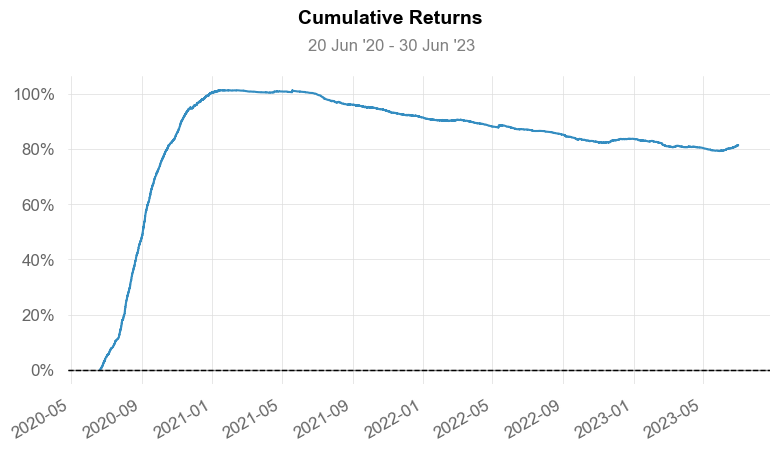

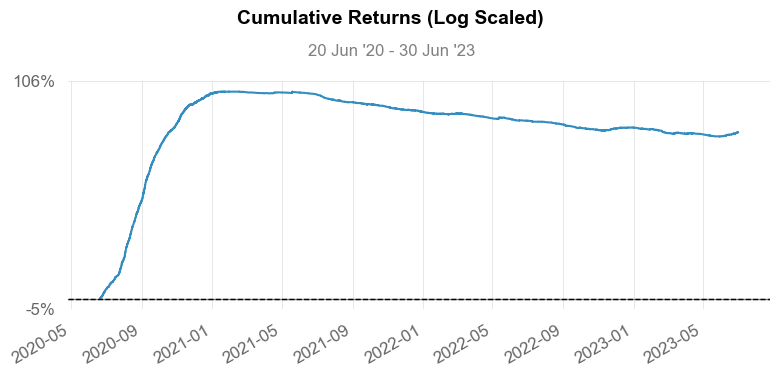

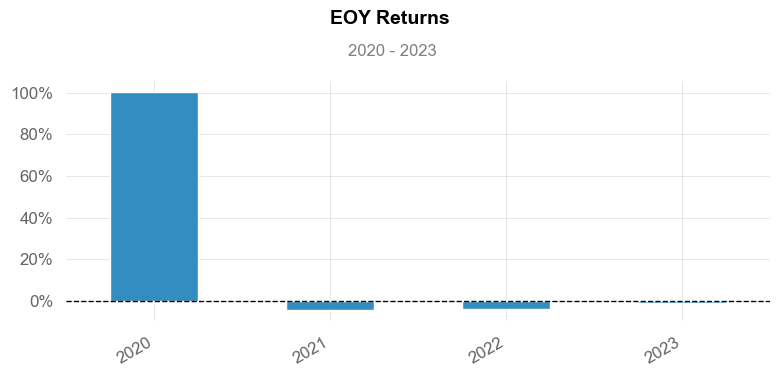

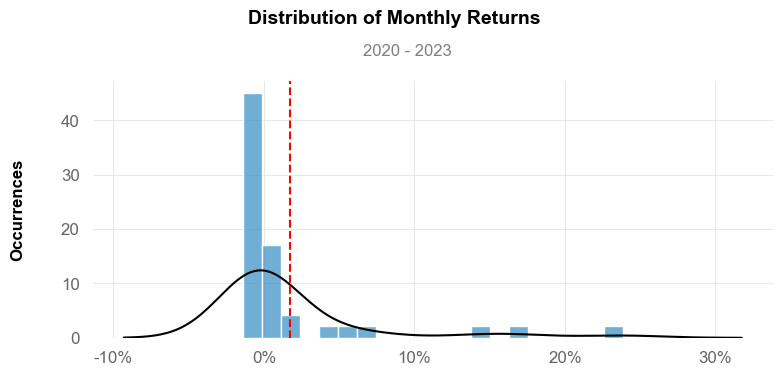

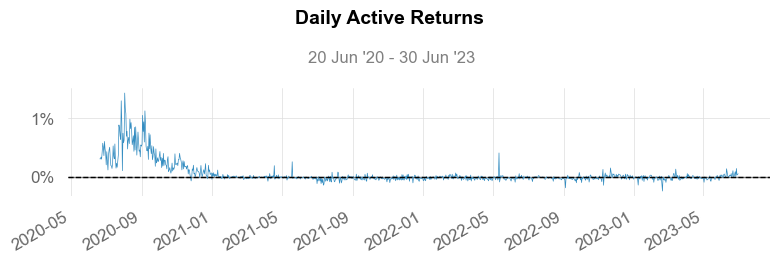

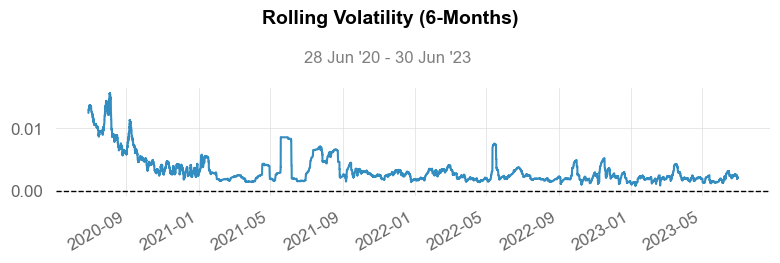

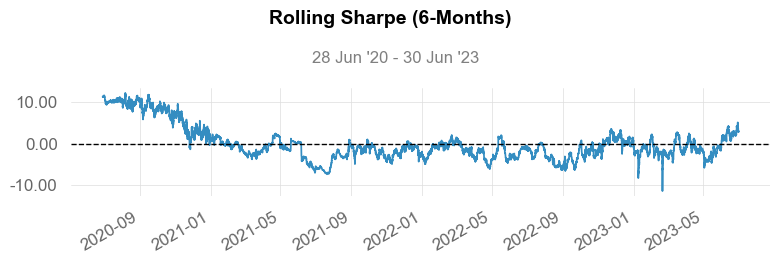

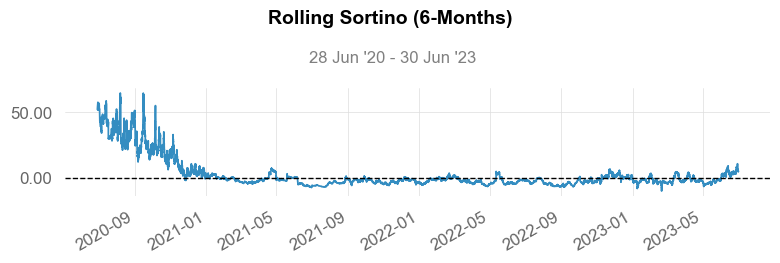

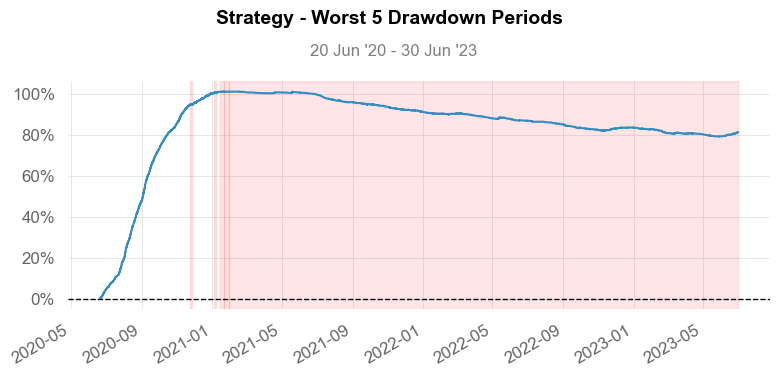

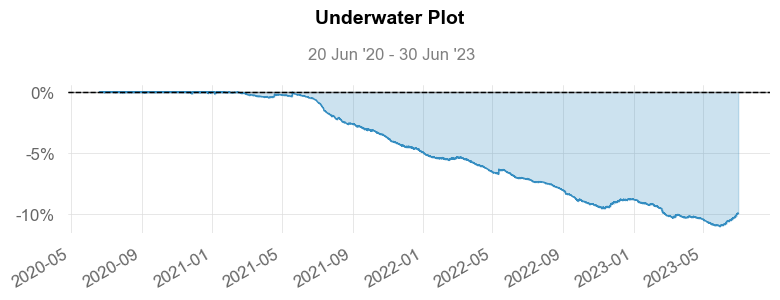

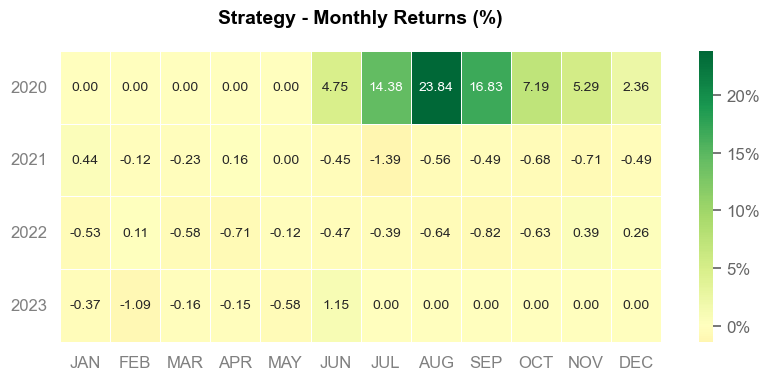

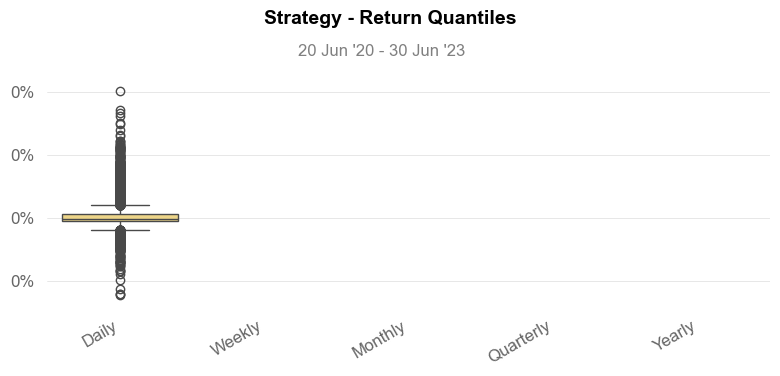

In [14]:
qs.reports.full(best_return['returns'])

### Analyze the test result

In [15]:
test_return = get_return(result_path + test_files[0])
get_metrics(test_return)

Compound annual growth rate: 52%
Total orders count: 4043
Total long action: 2097
Total short action: 1946
Won orders count: 2097
Lost orders count: 1946
Win/Loss order ratio: 1.0775950668037
Max win: values         1.191366
action         2.000000
zscore        27.655409
position       0.000017
price0      1994.250000
price1      1725.450000
pnl            0.003368
returns        0.001114
dtype: float64
Max Loss: values         1.000087
action         0.000000
zscore        -4.669323
position      -0.000011
price0      1445.710000
price1      1253.060000
pnl           -0.001314
returns       -0.000592
dtype: float64
Avg order pnl: -4.730138260965297e-05
Avg order pnl won: 5.1840870533908494e-05
Avg order pnl lost: -0.00013939583245245552
Avg long order pnl: -0.00015278246210804474
Avg short order pnl: -0.00016265736160393145


                           Strategy
-------------------------  ----------
Start Period               2023-07-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          19.14%
CAGR﹪                     33.68%

Sharpe                     4.09
Prob. Sharpe Ratio         100.0%
Smart Sharpe               2.67
Sortino                    7.09
Smart Sortino              4.64
Sortino/√2                 5.01
Smart Sortino/√2           3.28
Omega                      2.16

Max Drawdown               -0.31%
Longest DD Days            8
Volatility (ann.)          0.27%
Calmar                     109.82
Skew                       -1.41
Kurtosis                   32.88

Expected Daily %           0.0%
Expected Monthly %         3.56%
Expected Yearly %          19.14%
Kelly Criterion            25.87%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.02%
Expected Shortfall (cVaR)  -0.02%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-08,2023-11-09,2023-11-10,2,-0.306706,-0.304176
2,2023-08-10,2023-08-14,2023-08-17,8,-0.289391,-0.286908
3,2023-11-03,2023-11-05,2023-11-06,3,-0.219539,-0.217292
4,2023-08-19,2023-08-20,2023-08-21,3,-0.173919,-0.169930
5,2023-08-30,2023-08-31,2023-09-01,3,-0.113933,-0.099610


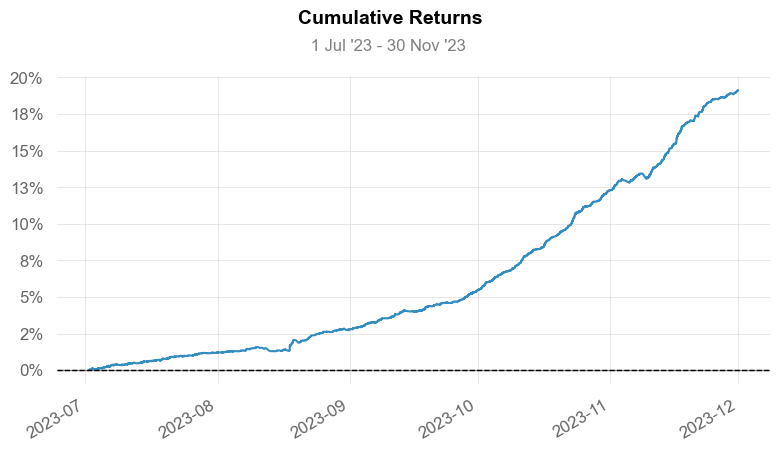

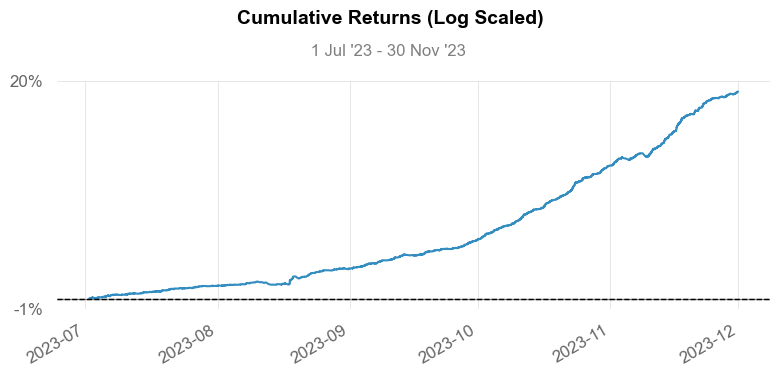

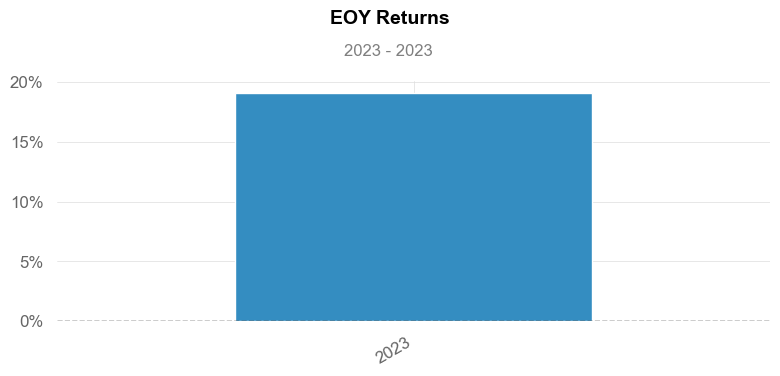

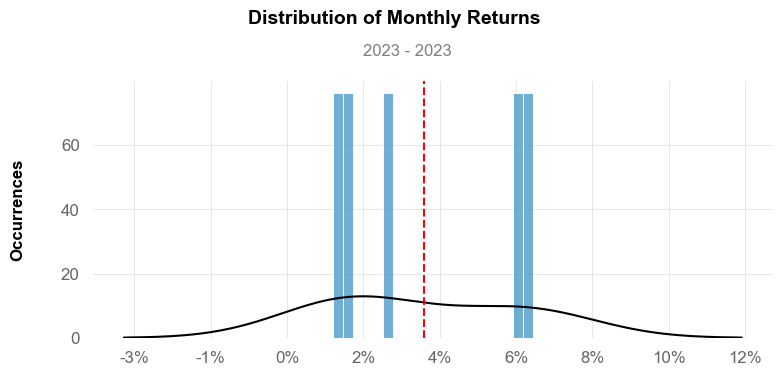

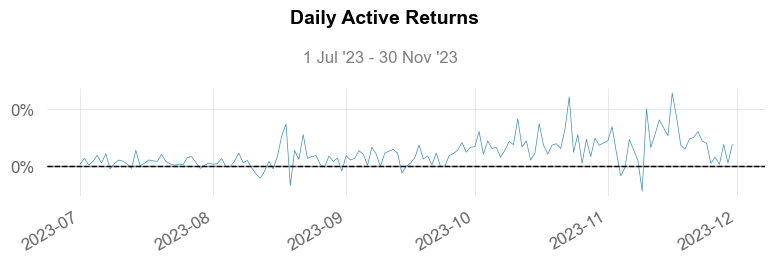

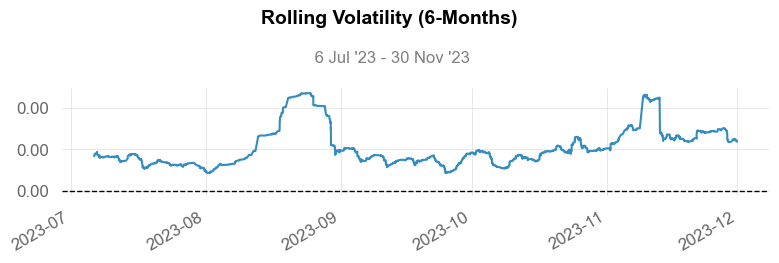

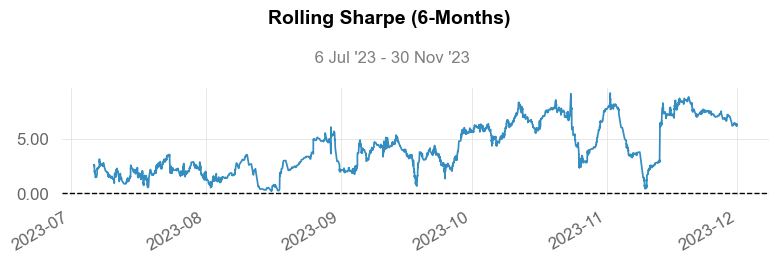

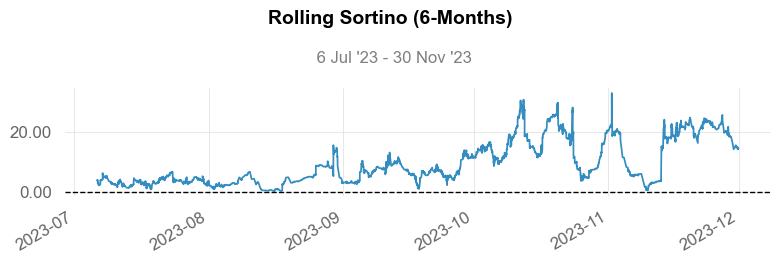

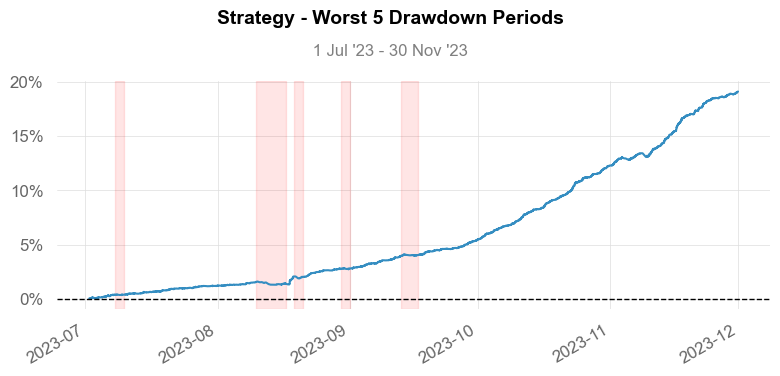

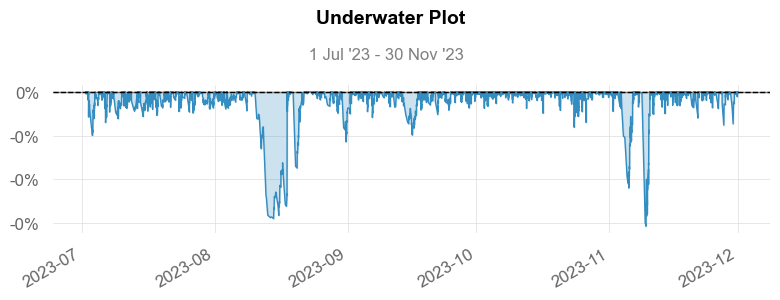

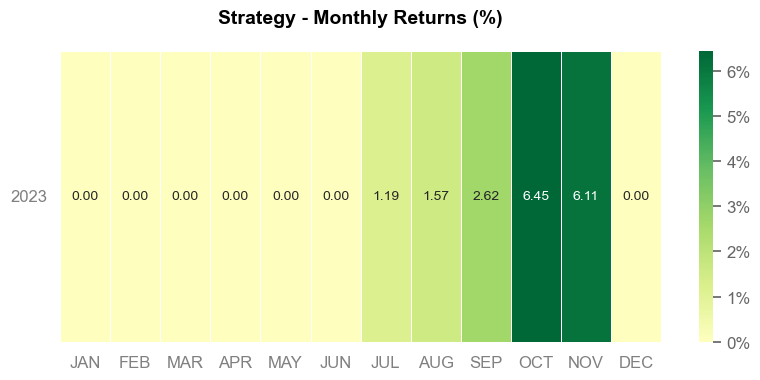

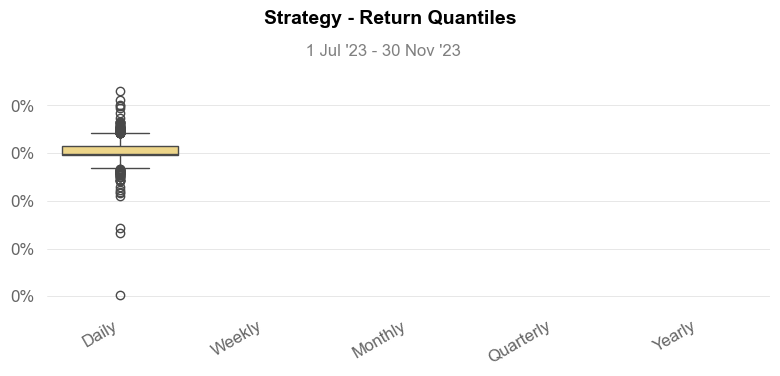

In [16]:
qs.reports.full(test_return['returns'])